- cross validation 実施
- 各fold の iteration まで全データで学習

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics, TimeSeriesSplitGroups

# Config

In [15]:
class cfg:
    exp = "exp012"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    n_splits = 5

    valid_ratio = 0.2
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [30]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")

targets = feature_metadata["targets"]

feature col length: 42


# Load Data

In [31]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,2,2,2,2,2,0,1,2,2,...,0.5,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.00,0.25
n003bba8a98662e4,0001,2,2,2,2,2,1,4,2,2,...,0.5,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25


(3577827, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0,2,1,2,2,1,1,2,2,...,0.50,0.75,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.75
n001e1318d5072ac,0575,1,1,3,2,1,3,3,4,4,...,0.25,0.25,0.25,0.0,0.25,0.25,0.25,0.25,0.25,0.00


# Preprocess

In [46]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

n_idx = int(len(data) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train, valid = data.iloc[:n_idx], data.iloc[n_idx:]

print(train.shape, valid.shape)


(1256185, 81) (1258696, 81)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target,era_int,pred
id,,,,,,,,,,,,,,,,,,,,,
nffc9b3ae035047c,1148,1,4,3,1,1,3,4,2,2,...,NaN,0.50,NaN,0.50,NaN,0.50,NaN,0.50,NaN,0.501108
nffccc8aca9ca182,1148,4,4,4,1,4,4,1,2,3,...,NaN,0.50,NaN,0.75,NaN,0.75,NaN,0.75,NaN,0.500813
nffd309f845e82b0,1148,4,3,4,1,3,4,4,4,0,...,NaN,0.50,NaN,0.50,NaN,0.50,NaN,0.50,NaN,0.500427
nffdea2939d23603,1148,1,2,1,1,0,2,2,4,1,...,NaN,0.75,NaN,0.75,NaN,0.75,NaN,0.75,NaN,0.499856
nfff50c01e0f417b,1148,1,4,2,3,0,3,1,3,3,...,NaN,0.50,NaN,0.50,NaN,0.50,NaN,0.75,NaN,0.500898


(2514881, 82)
2011904
(2011904, 82) (502977, 82)


In [39]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
cond_train = train["era_int"] % 4 == 0
train = train.loc[cond_train]

/tmp/ipykernel_16741/308992532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["era_int"] = train["era"].astype(int)


# Training

In [40]:
features = feature_set
target = "target"

In [41]:
cv = TimeSeriesSplitGroups(
    n_splits=cfg.n_splits
)

training_models = []

# target が null のデータを除外
cond_train = ~train[target].isnull()
cond_valid = ~valid[target].isnull()

print(train.shape, valid.shape)
train = train.loc[cond_train]
valid = valid.loc[cond_valid]
print(train.shape, valid.shape)


for i, (train_idx, valid_idx) in enumerate(cv.split(
    train[features],
    train[target],
    groups=train["era"]
)):
    x_train, y_train = train.iloc[train_idx][features], train.iloc[train_idx][target]
    x_valid, y_valid = valid.iloc[valid_idx][features], valid.iloc[valid_idx][target]
    print(x_train.shape, x_valid.shape)
    

    model = LightGBMModel(
        model_params=cfg.model_params,
    )
    model.train(
        x_train,
        y_train,
        eval_set=(x_valid, y_valid),
        early_stopping_rounds=10
    )

    # model.save_model(os.path.join(cfg.exp, f"model_{i}.pkl"))
    training_models.append(model)

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

(1256185, 81) (1258696, 80)
(1256185, 81) (1258696, 80)
(1013307, 42) (242878, 42)
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1013307, number of used features: 42
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Start training from score 

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 782998, number of used features: 42
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Start training from score 0

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 571364, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 376514, number of used features: 42
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Start training from score 0

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[269]	valid_0's l2: 0.0498781


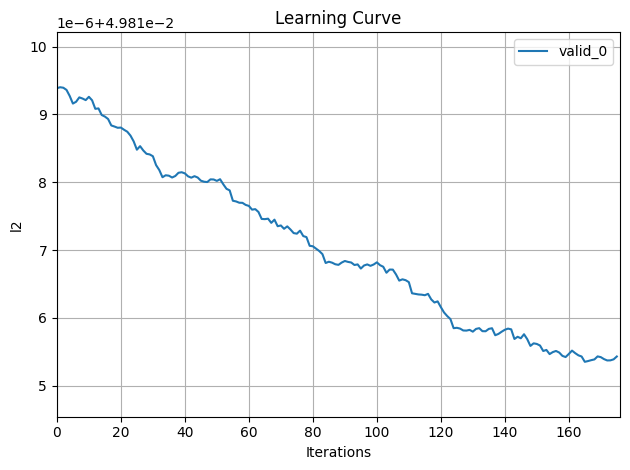

In [42]:
for model in training_models:
    model.visualize_learning_curve()
    break

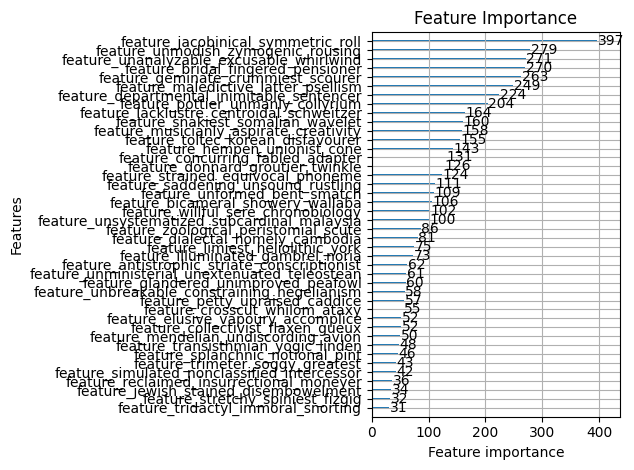

In [43]:
for model in training_models:
    model.visualize_feature_importance()
    break

# Validation

In [44]:
preds = np.zeros(len(valid))

for model in training_models:
    preds += model.predict(valid[features]) / len(training_models)


valid["pred"] = preds

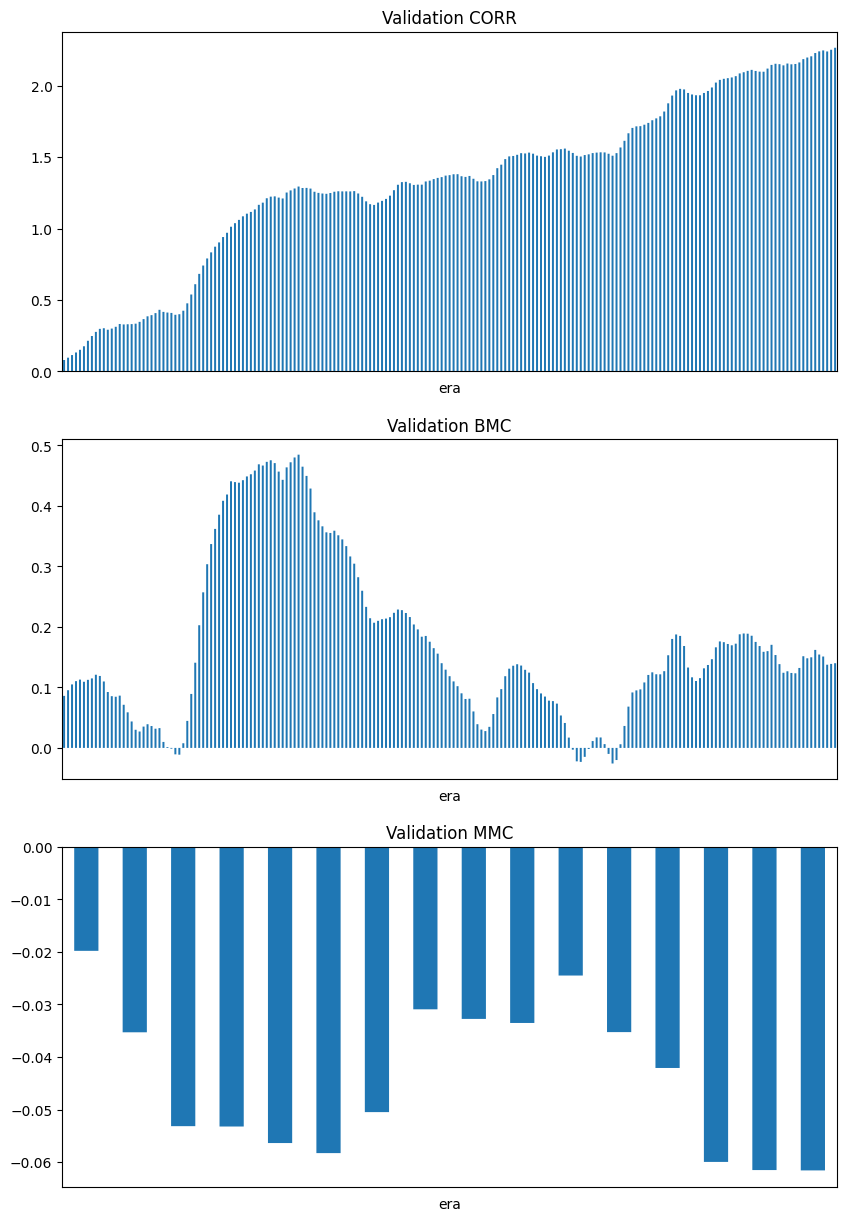

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean   mmc_std  \
 0   0.011627  0.019274    0.603248           0.128939 -0.003849  0.010776   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0  -0.357184          0.041794  0.000718  0.016633   0.043157   
 
    bmc_max_drawdown  
 0          0.510395  ,
           pred
 era           
 0954  0.079054
 0955  0.016274
 0956  0.018392
 0957  0.018085
 0958  0.018774
 ...        ...
 1144  0.011633
 1145  0.006690
 1146 -0.007379
 1147  0.011934
 1148  0.014008
 
 [195 rows x 1 columns],
           pred
 era           
 0954  0.085988
 0955  0.009343
 0956  0.009597
 0957  0.005412
 0958  0.002554
 ...        ...
 1144 -0.007650
 1145 -0.003282
 1146 -0.013545
 1147  0.001311
 1148  0.001160
 
 [195 rows x 1 columns],
           pred
 era           
 1133 -0.019789
 1134 -0.015504
 1135 -0.017866
 1136 -0.000068
 1137 -0.003147
 1138 -0.001914
 1139  0.007803
 1140  0.019568
 1141 -0.001828
 1142 -0.000772

In [45]:
caluculate_metrics(cfg.dataset_path, valid)

In [25]:
model.model.current_iteration()

20